# 好坏质检分类实战
1、基于data_class_raw.csv数据，根据高斯分布概率密度函数，寻找异常点并剔除  
2、基于data_class_processed.csv数据，进行PCA处理，确定重要数据维度及成分  
3、完成数据分离，数据分离参数：random_state=4,test_size=0.4  
4、建立KNN模型完成分类，n_neighbors取10，计算分类准确率，可视化分类边界  
5、计算测试数据集对应的混淆矩阵，计算准确率、召回率、特异度、精确率、F1分数  
6、尝试不同的n_neighbors(1-20),计算其在训练数据集、测试数据集上的准确率并作图  

In [1]:
#load the data
import pandas as pd
import numpy as np
data = pd.read_csv('data_class_raw.csv')
data.head()

,x1,x2,y
0,0.77,3.97,0
1,1.71,2.81,0
2,2.18,1.31,0
3,3.80,0.69,0
4,5.21,1.14,0


Text(0, 0.5, 'x2')

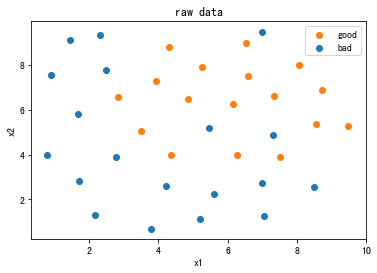

In [2]:
#define X and y
X = data.drop(['y'], axis=1)
y = data['y']
#visualize the data
from matplotlib import pyplot as plt
fig1 = plt.figure()
ax1 = fig1.add_subplot()
bad = ax1.scatter(X['x1'][y == 0], X['x2'][y == 0])
good = ax1.scatter(X['x1'][y == 1], X['x2'][y == 1])
ax1.legend((good, bad), ('good', 'bad'))
ax1.set_title('raw data')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

In [3]:
#anomaly detection
from sklearn.covariance import EllipticEnvelope
ad_model = EllipticEnvelope(contamination=0.02)
ad_model.fit(X[y == 0])
y_predict_bad = ad_model.predict(X[y == 0])
y_predict_bad

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1])

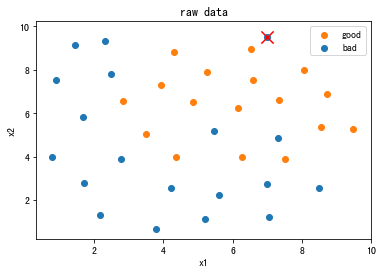

In [4]:
ax1.scatter(X['x1'][y == 0][y_predict_bad == -1],
            X['x2'][y == 0][y_predict_bad == -1],
            marker='x',
            s=150,
            c='r')
fig1

In [5]:
data = pd.read_csv('data_class_processed.csv')
data.head()

,x1,x2,y
0,0.77,3.97,0
1,1.71,2.81,0
2,2.18,1.31,0
3,3.80,0.69,0
4,5.21,1.14,0


<BarContainer object of 2 artists>

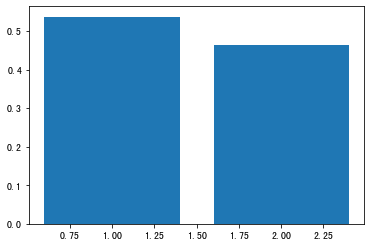

In [6]:
X = data.drop(['y'], axis=1)
y = data['y']
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_norm = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_norm)
var_ratio = pca.explained_variance_ratio_
plt.figure()
plt.bar([1, 2], var_ratio)

In [7]:
#train and test splt:random_state=4,test_size=0.4
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=4,
                                                    test_size=0.4)
#knn model
from sklearn.neighbors import KNeighborsClassifier
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_10.fit(X_train, y_train)
y_train_predict = knn_10.predict(X_train)
y_test_predict = knn_10.predict(X_test)
#calculate the accuracy
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)
print('training accuracy:', accuracy_train)
print('testing accuracy :', accuracy_test)

training accuracy: 0.9047619047619048
testing accuracy : 0.6428571428571429


In [8]:
#visualize the knn result and boundary
xx, yy = np.meshgrid(np.arange(0, 10, 0.05), np.arange(0, 10, 0.05))
x_range = np.c_[xx.ravel(), yy.ravel()]
x_range

array([[0.  , 0.  ],
       [0.05, 0.  ],
       [0.1 , 0.  ],
       ...,
       [9.85, 9.95],
       [9.9 , 9.95],
       [9.95, 9.95]])

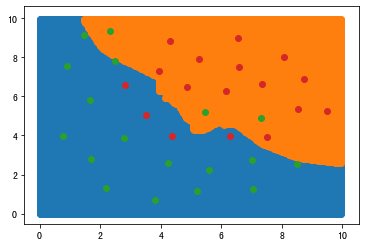

In [9]:
y_range_predict = knn_10.predict(x_range)
fig2 = plt.figure()
knn_bad = plt.scatter(x_range[:, 0][y_range_predict == 0],
                      x_range[:, 1][y_range_predict == 0])
knn_good = plt.scatter(x_range[:, 0][y_range_predict == 1],
                       x_range[:, 1][y_range_predict == 1])
bad = plt.scatter(X['x1'][y == 0], X['x2'][y == 0])
bad = plt.scatter(X['x1'][y == 1], X['x2'][y == 1])

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
cm

array([[4, 2],
       [3, 5]])

![confusion_matrix](images/06_confusion_matrix.png)

**准确率：**整体样本中，预测正确样本数的比例  
- Accuracy=(TP+TN)/(TP+TN+FP+FN)

In [11]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.6428571428571429

**召回率（灵敏度）：**正样本中，预测正确的比例  
- Recall=Sensitivity=TP/(TP+FN)

In [12]:
recall = TP / (TP + FN)
recall

0.625

**特异度：**负样本中，预测正确的比例  
- Specificity=TN/(TN+FP)

In [13]:
specificity = TN / (TN + FP)
specificity

0.6666666666666666

**精确率：**预测结果为正的样本中，预测正确的比例  
- PrecisionTP/(TP+FP)

In [14]:
precision = TP / (TP + FP)
precision

0.7142857142857143

**F1分数：**综合Precision和Recall的一个判断指标
- F1 Score=2*Precision$*$Recall/(Precision+Recall)

In [15]:
f1 = 2 * precision * recall / (precision + recall)
f1

0.6666666666666666

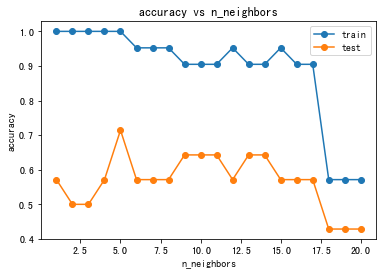

In [16]:
#try different k and calculate the accuracy for each
accuracy_train = []
accuracy_test = []
n = range(1, 21)
for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_train_predict = knn.predict(X_train)
    y_test_predict = knn.predict(X_test)
    accuracy_train_i = accuracy_score(y_train, y_train_predict)
    accuracy_test_i = accuracy_score(y_test, y_test_predict)
    accuracy_train.append(accuracy_train_i)
    accuracy_test.append(accuracy_test_i)
fig3 = plt.figure()
plt.title('accuracy vs n_neighbors')
accuracy_train, = plt.plot(n, accuracy_train, marker='o')
accuracy_test, = plt.plot(n, accuracy_test, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.legend((accuracy_train, accuracy_test), ('train', 'test'))

好坏质检分类实战summary:  
1、通过进行异常检测，帮助找到了潜在的异常数据点  
2、通过PCA分析，发现需要保留2维数据集  
3、实现了训练数据与测试数据的分离，并计算模型对于测试数据的预测准确率  
4、计算得到混淆矩阵，实现模型更全面的评估  
5、通过新的方法，可视化分类的决策边界  
6、通过调整核心参数n_neighbors值，在计算对应的准确率，可以帮助我们更好的确定使用哪个模型  